# NN model

## 1. First attempt without any optimisations
We use 4 features:
- text
- HasEmoji
- LengthCharacters
- DocumentType

### 1.1 Data reprocessing

In [27]:
# Load the data
df = pd.read_csv('data/prepared_data.csv')

# Select relevant columns
df = df[['cleaned_text', 'LabelMapped']]

In [29]:
df['LabelMapped'] = df['LabelMapped'].apply(lambda x: x + 1)  # Now -1 -> 0, 0 -> 1, 1 -> 2

In [30]:
df

,cleaned_text,LabelMapped
0,arrived broken manufacturer defect two of the ...,0
1,the cabinet dot were all detached from backing...,0
2,i received my first order of this product and ...,0
3,this product is a piece of shit do not buy doe...,0
4,went through in one day doesnt fit correct and...,0
...,...,...
255077,racaltosk ok good to know punting at metlife i...,2
255078,everyone who sat around me at metlife was so a...,1
255079,what giants or niners fans would wanna go to t...,1
255080,anybody want a ticket for tomorrow colombia vs...,2


### building the model

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Load the data
df = pd.read_csv('data/prepared_data.csv')
df = df[['cleaned_text', 'LabelMapped']]

# Encode labels (convert -1 to 0, 0 to 1, 1 to 2)
df['LabelMapped'] = df['LabelMapped'].apply(lambda x: x + 1)

# Ensure labels are correctly transformed
print(df['LabelMapped'].unique())  # Should print [0, 1, 2]

# One-hot encode labels
labels = to_categorical(df['LabelMapped'], num_classes=3)

# Split data into training and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['cleaned_text'], labels, test_size=0.2, random_state=42
)

# Tokenize the text
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Pad the sequences
max_length = 100
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

# Convert to numpy arrays
train_padded = np.array(train_padded)
test_padded = np.array(test_padded)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Check for NaNs or missing values
assert not np.any(np.isnan(train_padded)), "Train padded sequences contain NaNs"
assert not np.any(np.isnan(test_padded)), "Test padded sequences contain NaNs"
assert not np.any(np.isnan(train_labels)), "Train labels contain NaNs"
assert not np.any(np.isnan(test_labels)), "Test labels contain NaNs"

# Define the model
model = Sequential([
    Embedding(input_dim=10000, output_dim=64),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    GlobalAveragePooling1D(),
    Dense(24, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_padded,
    train_labels,
    epochs=10,
    validation_data=(test_padded, test_labels),
    verbose=2
)

# Evaluate the model
loss, accuracy = model.evaluate(test_padded, test_labels, verbose=2)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


[0 1 2]
Epoch 1/10
6378/6378 - 404s - 63ms/step - accuracy: 0.6318 - loss: 0.8045 - val_accuracy: 0.7039 - val_loss: 0.6766
Epoch 2/10
6378/6378 - 399s - 63ms/step - accuracy: 0.7110 - loss: 0.6705 - val_accuracy: 0.7171 - val_loss: 0.6471
Epoch 3/10
6378/6378 - 399s - 63ms/step - accuracy: 0.7346 - loss: 0.6263 - val_accuracy: 0.7197 - val_loss: 0.6392
Epoch 4/10
6378/6378 - 399s - 63ms/step - accuracy: 0.7521 - loss: 0.5889 - val_accuracy: 0.7187 - val_loss: 0.6477
Epoch 5/10
6378/6378 - 398s - 62ms/step - accuracy: 0.7701 - loss: 0.5543 - val_accuracy: 0.7140 - val_loss: 0.6648
Epoch 6/10
6378/6378 - 399s - 63ms/step - accuracy: 0.7844 - loss: 0.5200 - val_accuracy: 0.7122 - val_loss: 0.7098
Epoch 7/10
6378/6378 - 399s - 63ms/step - accuracy: 0.8009 - loss: 0.4845 - val_accuracy: 0.7068 - val_loss: 0.7617
Epoch 8/10
6378/6378 - 399s - 63ms/step - accuracy: 0.8154 - loss: 0.4510 - val_accuracy: 0.7025 - val_loss: 0.8017
Epoch 9/10
6378/6378 - 399s - 62ms/step - accuracy: 0.8298 - los

## Confusion matrix

1595/1595 - 32s - 20ms/step


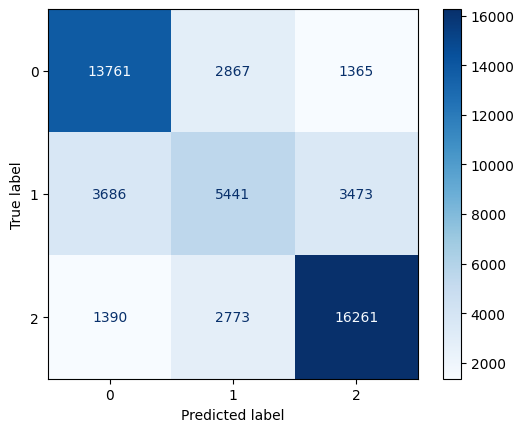

In [49]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict the class probabilities for the test set
predictions = model.predict(test_padded, verbose=2)

# Convert probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2])

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap=plt.cm.Blues)
plt.show()
